In [8]:
from gensim.models import Doc2Vec
from sklearn import decomposition
import numpy as np  
import sys
import operator
from sklearn import metrics
from sklearn import preprocessing
from sklearn import cross_validation
from adjustText import adjust_text
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import os
import heapq
import pandas as pd
import random as rnd
from random import shuffle
import collections
import matplotlib.ticker as ticker

from heapq import nlargest

from twitch import commons

%pylab inline
matplotlib.use('Agg')
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
df = pd.read_csv('./user_chat_counts.csv.dat', header=None, names=['user', 'total', 'male', 'female'])
df['female_chat_percentage'] = (df.female*100)/df.total

print('all users: ' + str(len(df.index)))

print('users with atleast 100 messages: ' + str(len(df[df.total >= 100].index)))

all_users = df[(df.total >= 100)]
selected_users = df[(df.total >= 100) & (df.female_chat_percentage >= 40) & (df.female_chat_percentage <= 60)]

users = selected_users.user.tolist()

no_of_users = len(users)
print('filtered users: ' + str(no_of_users))

all users: 1684452
users with atleast 100 messages: 77027
filtered users: 2734


In [25]:
print(df.total.get_values().std())
print(df.total.get_values().mean())
df.info()
df[df.total >= 617].info()

866.123220569
33.5442001316
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684452 entries, 0 to 1684451
Data columns (total 5 columns):
user                      1684452 non-null object
total                     1684452 non-null int64
male                      1684452 non-null int64
female                    1684452 non-null int64
female_chat_percentage    1684452 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 64.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12036 entries, 125 to 1684154
Data columns (total 5 columns):
user                      12036 non-null object
total                     12036 non-null int64
male                      12036 non-null int64
female                    12036 non-null int64
female_chat_percentage    12036 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 564.2+ KB


In [26]:
temp = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')]
female_channels = {}
for t in temp:
    female_channels[t] = 1

temp = [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')]
male_channels = {}
for t in temp:
    male_channels[t] = 1

In [27]:
gendered_terms = [r'\bhe\b', r'\bhes', r'\bshe\b', r'\bshes\b', r'\bhis\b', r'\bher\b', r'\bbro\b',
                  r'\bman\b', r'\bsir\b', r'\bdude\b', r'\bgirl\b', r'\bgirls\b', r'\blady\b',
                  r'\bgurl\b', r'\bhers\b', r'\bhisself\b', r'\bherself\b', r'\bman\b', r'\bwoman\b']

select_users = {}
for t in users:
    select_users[t] = 1

user_chats = {}

for file_name in os.listdir("../../data/channel_chat_logs/cleaned"):
    if file_name.endswith('.csv'):
        file_path = "../../data/channel_chat_logs/cleaned/" + file_name
        with open(file_path, 'r') as fp:
            #print('reading : ' + file_path)
            for line in fp:
                splits = line.split(",")
                channel = splits[1].replace('#', '')
                user = splits[2]
                message = splits[3]

                # avoiding users with less number of messages
                if user not in select_users:
                    continue
                
                if channel in male_channels:
                    user = user + "_m"
                else:
                    user = user + "_f"

                for temp in gendered_terms:
                    message = re.sub(temp, '', message)

                if len(message.strip()) == 0:
                    continue

                try:
                    user_chats[user].append(message.strip())
                except KeyError:
                    user_chats[user] = [message.strip()]
print('done')

done


In [28]:
class LabeledLineSentence(object):
    def __init__(self, messages_dic):
        self.documents = []
        self.messages_dic = messages_dic

    def __iter__(self):
        for user in self.messages_dic:
            messages_list = self.messages_dic[user]
            yield LabeledSentence((' '.join(messages_list)).split(), [user])

    def to_array(self):
        for user in self.messages_dic:
            messages_list = self.messages_dic[user]
            message_in_one_line = ' '.join(messages_list)
            self.documents.append(LabeledSentence(message_in_one_line.split(), [user]))
        return self.documents

    def sentences_perm(self):
        shuffle(self.documents)
        return self.documents

In [29]:
sentences = LabeledLineSentence(user_chats)
model = Doc2Vec(min_count=5, window=5, size=100, sample=1e-5, negative=5, workers=8, dm=0, dbow_words=1)
model.build_vocab(sentences.to_array())

for epoch in range(10):
    print('doc2vec epoch : ' + str(epoch))
    model.train(sentences.sentences_perm())
    model.save('mixed_gender_analysis.d2v')

doc2vec epoch : 0
doc2vec epoch : 1
doc2vec epoch : 2
doc2vec epoch : 3
doc2vec epoch : 4
doc2vec epoch : 5
doc2vec epoch : 6
doc2vec epoch : 7
doc2vec epoch : 8
doc2vec epoch : 9


In [5]:
model = Doc2Vec.load('./mixed_gender_analysis.d2v')

In [31]:
users_on_gender = []
for u in users:
    users_on_gender.append(u+"_f")
    users_on_gender.append(u+"_m")

## Cosine Similarities

In [57]:
random_female_gender_cosine_similarities = []
random_male_gender_cosine_similarities = []

same_user_cosine_similarities = []

random_users_1 = np.random.choice(users, 1000)
random_users_2 = np.random.choice(users, 1000)
for ru in random_users_1:
    same_user_cosine_similarities.append(commons.cosine_similarity(model.docvecs[ru+"_f"], model.docvecs[ru+"_m"]))
    
for i in range(1000):
    random_male_gender_cosine_similarities.append(commons.cosine_similarity(model.docvecs[random_users_1[i]+"_m"],
                                                                            model.docvecs[random_users_2[i]+"_m"]))
    
for i in range(1000):
    random_female_gender_cosine_similarities.append(commons.cosine_similarity(model.docvecs[random_users_1[i]+"_f"],
                                                                            model.docvecs[random_users_2[i]+"_f"]))

In [58]:
print(str(np.mean(same_user_cosine_similarities)) + ", " + str(np.std(same_user_cosine_similarities)) )
print(str(np.mean(random_male_gender_cosine_similarities)) 
      + ", " + str(np.std(random_male_gender_cosine_similarities)) )
print(str(np.mean(random_female_gender_cosine_similarities)) 
      + ", " + str(np.std(random_female_gender_cosine_similarities)) )

0.402906381595, 0.17735250326
0.155065242027, 0.0987871930416
0.157609477594, 0.0959067097744


## Classification

In [8]:
non_normalized_feature_vectors = [model.docvecs[x] for x in users_on_gender]

feature_vectors = preprocessing.normalize(preprocessing.scale(non_normalized_feature_vectors))

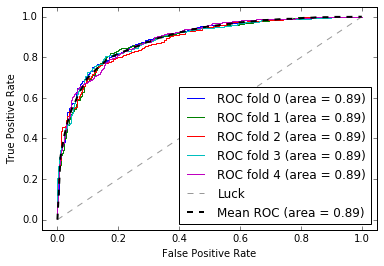

Accuracy: 0.81 (+/- 0.01)


In [9]:
y = np.array([1 if u.endswith('_f') else 0 for u in users_on_gender])
(lr, coef, _) = commons.build_lr_classification_model_cv(feature_vectors, y, 5)

In [10]:
all_words_dic = commons.read_word_count_file("../../data/word_counts/global_word_counts.csv")
all_words_list = sorted(all_words_dic.items(), key=operator.itemgetter(1), reverse=True)

In [11]:
selected_word_vectors = []
selected_words = []
count = 0
for w in all_words_list:
    if count < 10000:
        try:
            selected_word_vectors.append(model[w[0]])
            selected_words.append(w)
            count += 1
        except:
            continue
    else:
        break
selected_word_vectors = preprocessing.normalize(preprocessing.scale(selected_word_vectors))

In [12]:
word_similarity_dic = {}
for i,w in enumerate(selected_words):
    try:
        word_similarity_dic[w[0]] = lr.predict_proba(selected_word_vectors[i].reshape(1, -1))[0][1]
    except:
        continue

In [13]:
top_female_words = heapq.nlargest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_female_words))

print('')

top_male_words = heapq.nsmallest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_male_words))

beautiful, cute, marry, cat, makeup, hair, cleavage, hot, boyfriend, costume, look, thirsty, gorgeous, sonya, show, kitty, tits, snapchat, body, adorable, booobs, jealous, youre, dress, eyebrows

bungie, gp, replay, hltv, jayce, blackscreen, comeback, vs, fp, chopper, olaf, resets, runners, monk, jg, yooo, marksman, rotation, ez, reus, mid, clips, glyph, alienware, charge


## t-SNE

In [25]:
all_xy_vectors = commons.reduce_dim(feature_vectors, 'tsne')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5468
[t-SNE] Computed conditional probabilities for sample 2000 / 5468
[t-SNE] Computed conditional probabilities for sample 3000 / 5468
[t-SNE] Computed conditional probabilities for sample 4000 / 5468
[t-SNE] Computed conditional probabilities for sample 5000 / 5468
[t-SNE] Computed conditional probabilities for sample 5468 / 5468
[t-SNE] Mean sigma: 0.295390
[t-SNE] Iteration 25: error = 1.9286128, gradient norm = 0.0096764
[t-SNE] Iteration 50: error = 1.8853968, gradient norm = 0.0063440
[t-SNE] Iteration 75: error = 1.7092092, gradient norm = 0.0020520
[t-SNE] Iteration 100: error = 1.6716113, gradient norm = 0.0017275
[t-SNE] Error after 100 iterations with early exaggeration: 1.671611
[t-SNE] Iteration 125: error = 1.6057370, gradient norm = 0.0013218
[t-SNE] Iteration 150: error = 1.5840074, gradient norm = 0.0012189
[t-SNE] Iteration 1

In [26]:
colors = ['#63c17e' if y[i] == 1 else '#1F1F1F' for i in range(len(all_xy_vectors))]

(-13, 12)

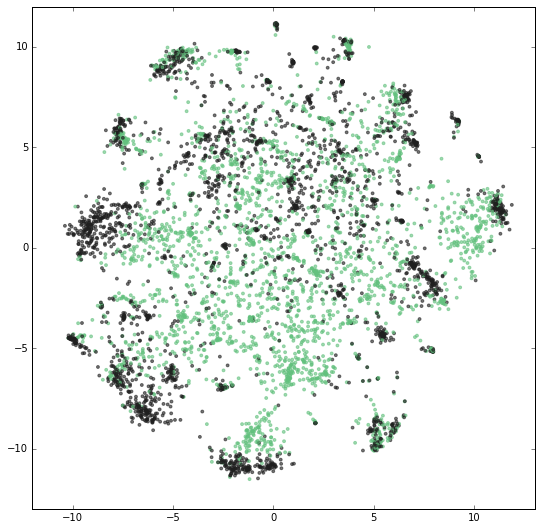

In [31]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

plt.scatter([x[0] for x in all_xy_vectors],
            [y[1] for y in all_xy_vectors],
            s=8, color=colors, lw=1, alpha=0.6)

plt.xlim(xmin=-12, xmax=13)
plt.ylim(ymin=-13, ymax=12)

## BoW method

In [14]:
tf = TfidfVectorizer(analyzer='word', max_features=10000, stop_words = 'english')

In [15]:
cleaned_channel_log = [' '.join(user_chats[x]) for x in users_on_gender]
x = tf.fit_transform(cleaned_channel_log)

In [16]:
x = preprocessing.normalize(x)
feature_names = tf.get_feature_names() 

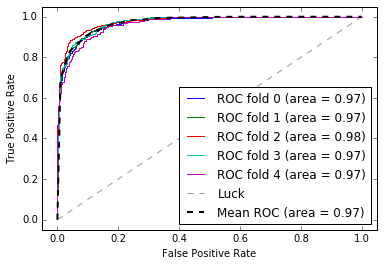

Accuracy: 0.91 (+/- 0.02)


In [17]:
clf,coef,_ = commons.build_lr_classification_model_cv(x, y, 5)

In [18]:
print('Female words : ' + ', '.join([feature_names[i] for i in coef[0].argsort()[-25:][::-1]]))
print('')
print('Male words : ' + ', '.join([feature_names[i] for i in (- coef[0]).argsort()[-25:][::-1]]))

Female words : kitty, boobs, lea, emily, tits, kaceytron, ally, alisha, hafu, becca, nadia, dizzy, echo, cat, kacey, hair, muse, michi, shy, lauren, cosplay, sovi, cute, mitten, dragon

Male words : moe, nelson, hutch, abdou, coty, chris, arnie, mr, boogie, bbg, pobelter, fow, alfie, cdew, chief, frag, max, caleb, valkrin, anthony, dm, rajj, ferret, monster, timmac
